In [262]:
import os
import sys

In [263]:
import string
import itertools
import math
import time
import datetime
import json
import pyodbc
import numpy as np
import pandas as pd

from functools import singledispatch
from collections import Counter

# singledispatchmethod in functools from python3.8+
try:
    from functools import singledispatchmethod
except ImportError:
    from singledispatchmethod import singledispatchmethod

# Gensim
import gensim
import gensim.corpora as corpora

from gensim.utils import simple_preprocess
from gensim.models import LdaModel, CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk
#nltk.download('stopwords') #only on first install

from nltk.corpus import stopwords

In [264]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','please','au', 'hi','hello','help',
                  'find','cant','one','still','ask','st','yes','im','dont','none','cannot',
                  'want','know','see','whats','could','back','would_like','wondering','able',
                  'hey','need','get','take','like','copy','nan','writing','ok','appreciate',
                  'okay','thanks','make','trying','another','havent','would','thank','yet','receive',
                  'looking','someone', 'contact_us', 'popular_questions','already','idont',
                  'ive','wanted','today','first','information','talk','person','long','work',
                  'week','regarding','questions','two','pm','sent','got','says','whether','youll',
                  'said', 'hi', 'dear', 'hello'])
stop_words.extend(['question', 'related', 'detail','found','otherwise','sorry','understand','try','rephrase','try','go','either',
                  'however','includes','wish','also','sure','may','must','including','would'])
stop_words.extend(['regard', 'give', 'let'])

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

/opt/anaconda3/lib/python3.8/site-packages/spacy/language.py:1895: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


In [265]:
text = pd.read_csv('Archibus WR Data_2021-2022_20221018.csv')
df = text.head(5000)

In [266]:
from io import StringIO

col = ['PROB_TYPE', 'DESCRIPTION']
df = df[col]
df = df[pd.notnull(df['DESCRIPTION'])]
df.columns = ['PROB_TYPE', 'DESCRIPTION']
df['category_id'] = df['PROB_TYPE'].factorize()[0]
df.head()

,PROB_TYPE,DESCRIPTION,category_id
0,ELECTRICAL SERVICES,"Dear COS, the lights in the male toilet on lev...",0
1,PLUMBING SERVICES,The zip tap in the library staff room is not w...,1
2,LIGHTING,"Lights are currently out, previously occurred ...",2
3,BLDG ACCESSCARDS,Can i please get access for Celine\tBoehm\t116...,3
4,FIRE SERVICES,NON CRITICAL DEFECT\nThe syphonics pipe collar...,4


In [267]:
category_id_df = df[['PROB_TYPE', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)

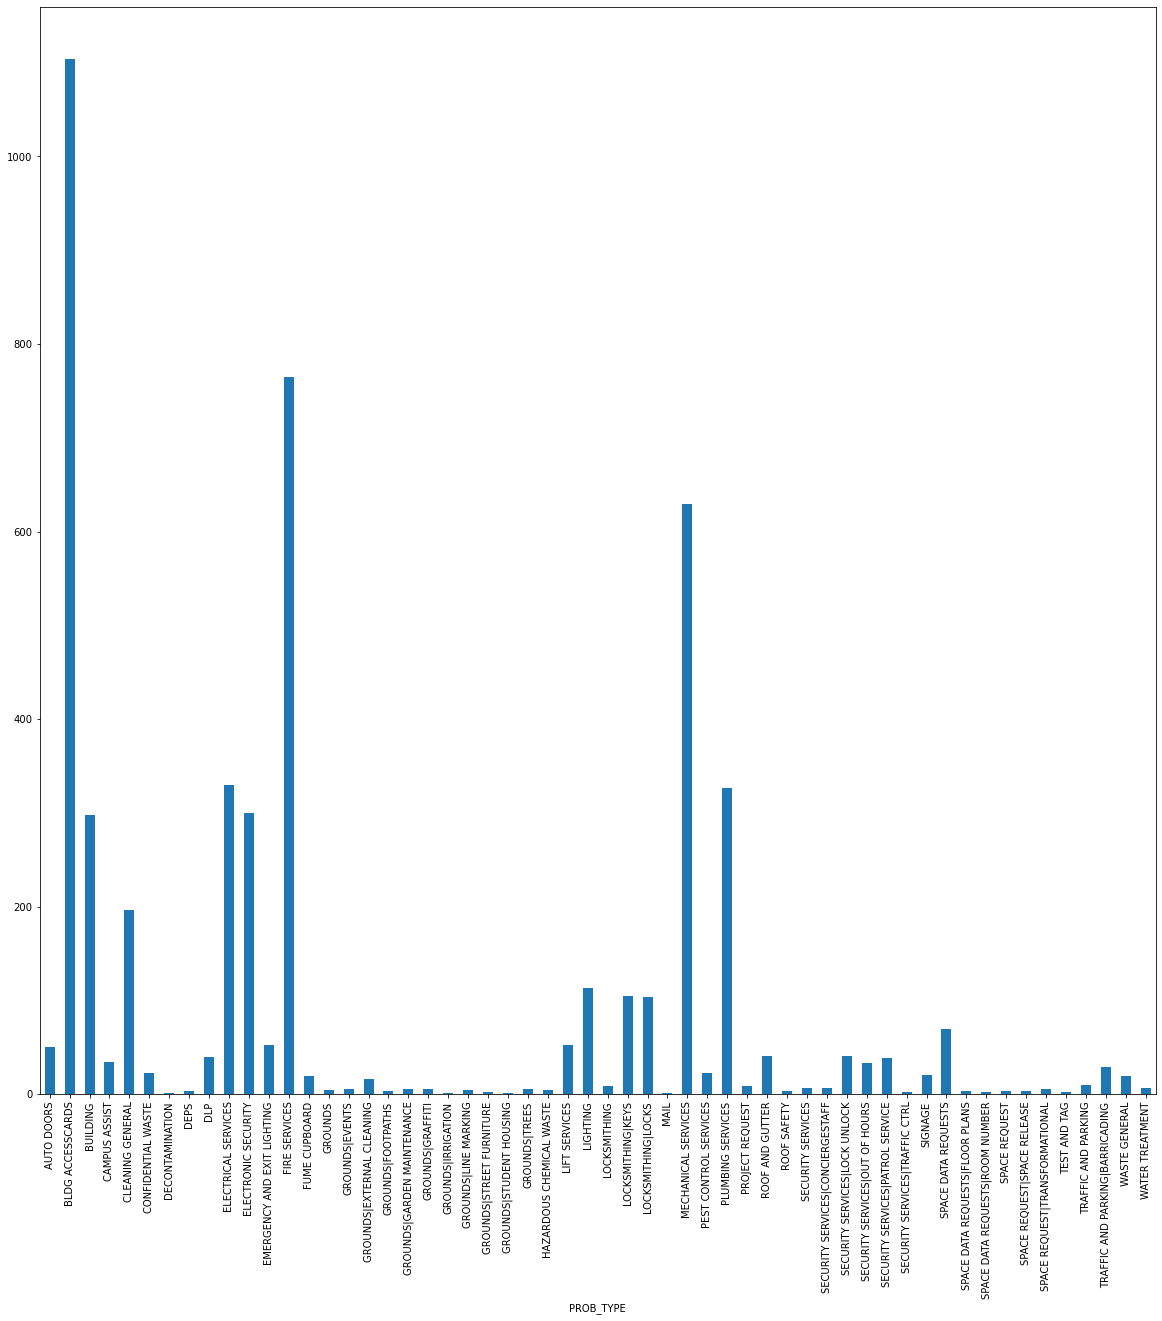

In [268]:
fig = plt.figure(figsize=(20,20))
df.groupby('PROB_TYPE').DESCRIPTION.count().plot.bar(ylim=0)
plt.show()

In [269]:
#Data cleaning
class Preprocessor:
    
    def __init__(self):
        self.punct = list(string.punctuation.replace("'", '’'))
        self.token_list = [
          '|', '------','____','If you have received this email in error ','Any use, distribution, disclosure, or copying of this email','cheers', 'regards', 'best regards', 'kind regards',
          'sent from:', 'from:', 'sent:', 'to:', 'cc:', 'subject:', 'Sender:','date: ',' outlook for', '<https://protect','This short survey will take','how satisfied or dissatisfied are you with our',
          'CISCO', '[image]', '.pdf', '[cid:', 'Giving today. Changing tomorrow.','If you have a different query, you will need to submit a new enquiry', 
          'See the impact<', 'This email plus any attachments to it are confidential. Any unauthori','Read through your handbook<http','find out what you will need to enrol in your new course<https',
          'We acknowledge and respect the', 'Please think of our environment','If you are not satisfied with this response, you can re-open the enquiry',
          'This e-mail may contain information which is confidential', 'Before commencing your research you will need to enrol, to review the details of your approved',
          'This email (including any attachments) may contain confidential','We acknowledge the traditional custodians of the land','This communication may contain information that is proprietary',
          'Views expressed in this email are those of the individual sender, and are not necessarily the views of', 'You can find out how to suspend your studies<https',
          'This email plus any attachments to it are confidential','for any other general enquiries you are welcome to contact the Student Centre',
          '=========', 'Please quote your full name and student number in all correspondence with the University.','Your student card is valid for the duration of your enrolment',
          'Please use your student email account if you are a current student for all communication with the University.','Thinking about taking a break from your studies',
          'The majority of correspondence issued by the University of Sydney is sent via email. In order to ensure','You can find more information about enrolment<',
          'To update this case please click on the link in the email below, or alternatively reply above this lin','After you have successfully enrolled, we will send a confirmation summary to your University student',
          'If you receive this email in error', 'It is strictly forbidden to share any part of this message','If you have any questions, call us on 1800 SYD UNI'
        ]
        self.token_list = [t.lower() for t in self.token_list]
    
    def __call__(self, *args, **kwargs):
        if isinstance(args[0], list):
            [self(arg) for arg in args[0]]
        elif isinstance(args[0], pd.DataFrame):
            self.replace_DESCRIPTION(args[0])
            self.remove_blacklisted_sentences(args[0])
        else:
            raise ValueError
            
    def remove_punctuations(self, text):
        for punctuation in self.punct:
            text = text.replace(punctuation, ' ')
        return text

    def str_blacklist(self, string):
        str_list = string.split('\n')
        return '\n'.join([s for s in str_list if not any(t in s.lower() for t in self.token_list) and len(s) != 0])
      
    def remove_blacklisted_sentences(self, df):
        df['DESCRIPTION'] = df['DESCRIPTION'].apply(self.str_blacklist)

    def replace_DESCRIPTION(self, df):

        df['DESCRIPTION'] = df['DESCRIPTION'].astype(str)
        
        df['DESCRIPTION'] = df['DESCRIPTION'].apply(lambda x: x.lower())
        df['DESCRIPTION'] = df['DESCRIPTION'].apply(lambda x: x.replace('\n', ' '))
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace('http\S+|www.\S+', '', regex=True)
        df['DESCRIPTION'] = df['DESCRIPTION'].apply(lambda x: x.replace('&gt;', ''))
        df['DESCRIPTION'] = df['DESCRIPTION'].apply(self.remove_punctuations)
        df['DESCRIPTION'] = df['DESCRIPTION'].apply(lambda x: str(x).replace(" s ", " "))

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace("\r", " ", case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(' university of sydney',' usyd ', case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(' university ', ' usyd ', case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(' uni ',' usyd ',case=False)  #do not use this line it will mess up unit as usydt
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace("sydney student","sydney_student",case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace("contact us", "contact_us", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace("popular questions","popular_questions", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(' center ',' centre ',case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace("student centre", "student_centre", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace("unit of study","unit_of_study", case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" units of study "," unit_of_study ",case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" masters "," master ", case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace("online enquiry", "online_enquiry", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace("online inquiry", "online_inquiry", case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" re enrol "," re_enrol ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" enroll ", " enrol ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" enrolment "," enrol ",case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" enroling "," enrol ",case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" enroled "," enrol ",case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" enrolled "," enrol ", case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" re enrollment ", " re_enrol ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" student id " , " student_id ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" log into "," login ",case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" log in "," login ",case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace("error message ", " error_message ", case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" international students ", " international_students ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" international student ", " international_students ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" first year ", " first_year ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" final year ", " final_year ", case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" census date ", " census_date ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" none of the above ", " none_of_the_above ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(' units ',' unit ', case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" SID ", " student_id ", case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" summer school "," summer_school ",case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" collecting "," collection ",case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" collect "," collection ",case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" studies "," study ",case=False)
        #new
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" students ", " student ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" covid", " coronavirus ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" corona virus ", " coronavirus ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" suspension ", " suspend ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" universitys ", " usyd ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" begin ", " start ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" face to face ", " face_to_face", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" reenrol", " re_enrol", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" australian ", " australia ", case=False)

In [270]:
class Corpus:
    
    def __init__(self, nlp, stop_words):
        self.stop_words = set(stop_words)
        self.nlp = nlp
        
    def __call__(self, df, key='DESCRIPTION', **kwargs):
        self.data_lemmatized(df, key)
        
    def data_words(self, series):
        return list(self.sent_to_words(series.values.tolist()))
    
    def sent_to_words(self, sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
    
    def make_bigrams(self, bigram_mod, texts):
        return [bigram_mod[doc] for doc in texts]
    
    def remove_stopwords(self, texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in self.stop_words] for doc in texts]
    
    def lemmatization(self, texts, allowed_postags=('NOUN', 'VERB')):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = self.nlp(" ".join(sent))
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out
    
    @singledispatchmethod
    def data_lemmatized(self, series, key='DESCRIPTION', **kwargs):
        data_words = self.data_words(series)
        data_words_nostops = self.remove_stopwords(data_words)
        
        bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
        bigram_mod = gensim.models.phrases.Phraser(bigram)
        
        data_words_bigrams = self.make_bigrams(bigram_mod, data_words_nostops)
        
        return self.lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'VERB'])
    
    @data_lemmatized.register(list)
    def _(self, df_list, key='DESCRIPTION', **kwargs):
        return [self.data_lemmatized(df, key, **kwargs) for df in df_list]
    
    @data_lemmatized.register(pd.DataFrame)
    def _(self, df, key='DESCRIPTION', out_key='data_words', **kwargs):
        df[out_key] = self.data_lemmatized(df[key], key='DESCRIPTION', **kwargs)

In [271]:
preprocessor = Preprocessor()
preprocessor(df)

corpus_constructor = Corpus(nlp, stop_words)
corpus_constructor(df)

In [272]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), norm = 'l2', min_df = 8) 
features = tfidf.fit_transform(df.DESCRIPTION).toarray()

labels = df.category_id
features.shape

(5000, 3029)

In [273]:
from sklearn.feature_selection import chi2

In [293]:
# Finding the three most correlated terms with each of the product categories
N = 15
for PROB_TYPE, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    a = [PROB_TYPE], 
    b = ["Most Important Unigram Keywords are: %s" %(', '.join(unigrams[-N:]))]
    c = ["Most Important Bigram Keywords are: %s" %(', '.join(bigrams[-N:]))]

In [294]:
rows = [a,b,c]

In [295]:
col = ['PROB_TYPE', 'Unigram Keywords', 'Bigram Keywords']

In [296]:
import csv
with open ('Output.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(col)
    write.writerows(zip(*rows))